In [1]:
import mbuild as mb
from foyer import Forcefield
from mbuild.lib.recipes.polymer import Polymer
import unyt as u

import mosdef_cassandra as mc

/Users/quachcd/Documents/dev/env/mbuild/mbuild/utils/decorators.py:134: Warning: freud_generate_bonds is an experimental feature and is not subject to follow standard deprecation cycles. Use at your own risk! 
  warn(


## Prepare recipes

### Exercise 1

In [2]:
class _CH2(mb.Compound):
    def __init__(self):
        super().__init__()
        self.name = "_CH2"
        # Create a partilce name _CH2
        _ch2 = mb.Compound(name="_CH2")
        self.add(_ch2, "_CH2")
        
        # Create ports to be attached to the _CH2 particles
        port_up = mb.Port(anchor=_ch2, orientation=[0, 0, 1], separation=0.07)
        port_down = mb.Port(anchor=_ch2, orientation=[0, 0, -1], separation=0.07)
        self.add(port_up, "up")
        self.add(port_down, "down")
        
class _CH3(mb.Compound):
    def __init__(self):
        super().__init__()
        self.name = "_CH3"
        
        # Create a particle name _CH3
        _ch3 = mb.Compound(name="_CH3")
        self.add(_ch3, "_CH3")
        
        # Create a port to be attached to the _CH3 particle
        port_up = mb.Port(anchor=_ch3, orientation=[0, 0, 1], separation=0.07)
        self.add(port_up, "up")

            

### Exercise 2 

In [3]:
class CG_Alkane(mb.Compound):
    def __init__(self, n):
        super().__init__()
        self.name = "CG_Alkane"
    
        if n == 1: 
            _ch4 = mb.Compound(name="_CH4")
            self.add(_ch4, "_CH4")
        elif n == 2:
            _ch3a = _CH3() 
            _ch3b = _CH3() 
            self.add(_ch3a, "_CH3_a")
            self.add(_ch3b, "_CH3_b")
            mb.force_overlap(move_this=_ch3a, 
                             from_positions=_ch3a["up"], 
                             to_positions=_ch3b["up"])
        else:
            _ch3top = _CH3()
            self.add(_ch3top, "link0")
            for i in range(n - 2):
                _ch2 = _CH2()
                mb.force_overlap(move_this=_ch2, 
                                 from_positions=_ch2["down"],
                                 to_positions=self[f"link{i}"]["up"])
                self.add(_ch2, f"link{i+1}")
                
            _ch3bot = _CH3()
            self.add(_ch3bot, f"link{i+2}")
            mb.force_overlap(move_this=_ch3bot, 
                             from_positions=_ch3bot["up"], 
                             to_positions=self[f"link{i+1}"]["up"])


In [4]:
from mbuild.lib.recipes import Polymer

cg_alkane = Polymer(monomers=[_CH2()], end_groups=[_CH3(), _CH3()])
cg_alkane.build(n=5)

### Exercise 3

In [5]:
n_pentane = CG_Alkane(5)
pentane_box = mb.fill_box(compound=n_pentane, 
                          n_compounds=150, 
                          box=[3.2, 3.2, 3.2],
                          seed=12345, 
                          edge=0.2)

/Users/quachcd/Documents/dev/env/mbuild/mbuild/conversion.py:1763: UserWarning: No element attribute associated with '<_CH3 pos=([0. 0. 0.]), 1 bonds, id: 6094461680>'; and no matching elements found based upon the compound name. Setting atomic number to zero.
  warn(warn_msg)
/Users/quachcd/Documents/dev/env/mbuild/mbuild/conversion.py:1763: UserWarning: No element attribute associated with '<_CH2 pos=([ 9.6244e-18 -8.3696e-18  1.4000e-01]), 2 bonds, id: 6094513392>'; and no matching elements found based upon the compound name. Setting atomic number to zero.
  warn(warn_msg)
/Users/quachcd/Documents/dev/env/mbuild/mbuild/formats/xyz.py:68: UserWarning: No matching element found for EP; the particle will be added to the compound without an element attribute.
  warn(


### Exercise 4

In [6]:
import foyer 
from foyer import Forcefield

trappe = Forcefield(name="trappe-ua")
pentane_box.energy_minimize(forcefield="trappe-ua", 
                            steps=10**6)

pentane_box.visualize()


/Users/quachcd/mambaforge/envs/general/lib/python3.9/site-packages/foyer/forcefield.py:665: UserWarning: Non-atomistic element type detected. Creating custom element for _CH4
  warnings.warn(
/Users/quachcd/mambaforge/envs/general/lib/python3.9/site-packages/foyer/forcefield.py:665: UserWarning: Non-atomistic element type detected. Creating custom element for _CH3
  warnings.warn(
/Users/quachcd/mambaforge/envs/general/lib/python3.9/site-packages/foyer/forcefield.py:665: UserWarning: Non-atomistic element type detected. Creating custom element for _CH2
  warnings.warn(
/Users/quachcd/mambaforge/envs/general/lib/python3.9/site-packages/foyer/forcefield.py:665: UserWarning: Non-atomistic element type detected. Creating custom element for _HC
  warnings.warn(
/Users/quachcd/Documents/dev/env/mbuild/mbuild/conversion.py:1763: UserWarning: No element attribute associated with '<_CH3 pos=([0.8894 2.0599 2.5947]), 1 bonds, id: 6094589664>'; and no matching elements found based upon the compou

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Exercise 5a - Simulation with MoSDeF Cassandra

In [ ]:
%cd mc_sim/
# Load forcefields
trappe = Forcefield(name="trappe-ua")

# Use foyer to apply forcefields
typed_pentane = trappe.apply(n_pentane)
species_list = [typed_pentane]

# Create box and species list
box_list = [pentane_box]
mols_in_boxes = [[150]]

system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)
moveset = mc.MoveSet("npt", species_list)

moveset.prob_volume = 0.010

thermo_props = [
    "energy_total",
    "energy_intervdw",
    "pressure",
    "volume",
    "nmols",
    "mass_density",
]

custom_args = {
    "run_name": "equil",
    "charge_style": "none",
    "rcut_min": 2.0 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "units": "sweeps",
    "steps_per_sweep": 450,
    "coord_freq": 50,
    "prop_freq": 10,
    "properties": thermo_props,
}


mc.run(
    system=system,
    moveset=moveset,
    run_type="equilibration",
    run_length=2400,
    pressure=14.02 * u.bar,
    temperature=372 * u.K,
    **custom_args,
)
%cd ..

### Exercise 5b - Simulation with GROMACS

In [12]:
pentane_box.save("gmx_sim/init.gro", overwrite=True)
pentane_box.save("gmx_sim/init.top", forcefield_name="trappe-ua", overwrite=True)

In [13]:
em_mdp = """
integrator          = steep
nsteps              = 500000
emstep              = 0.002
emtol               = 10
dt                  = 0.002

nstxout             = 10000
nstvout             = 10000
nstenergy           = 1000
nstlog              = 1000

cutoff-scheme       = Verlet
ns_type             = grid
nstlist             = 10

vdwtype         = Cut-off
vdw-modifier    = None
rvdw            = 1.4

coulombtype             = Cut-off
coulomb-modifier        = None
rcoulomb                = 1.4

gen_vel             = yes
gen-temp            = 372.0
gen-seed            = 4

tcoupl              = no

pcoupl              = no

pbc                 = xyz

DispCorr            = EnerPres

constraint-algorithm = LINCS
constraints         = all-bonds
"""

nvt_mdp = """
integrator          = md
nsteps              = 1000000
dt                  = 0.001

comm-mode           = Linear

nstxout             = 10000
nstvout             = 10000
nstenergy           = 1000
nstlog              = 1000

cutoff-scheme       = Verlet
ns_type             = grid
nstlist             = 10
pbc                 = xyz

vdwtype         = Cut-off
vdw-modifier    = None
rvdw            = 1.4

coulombtype             = Cut-off
coulomb-modifier        = None
rcoulomb                = 1.4

tcoupl              = nose-hoover
tc-grps             = System
tau_t               = 1
ref_t               = 372.0

pcoupl              = no

DispCorr            = EnerPres

constraint-algorithm = LINCS
constraints         = all-bonds
"""

npt_mdp = """
integrator          = md
nsteps              = 1000000
dt                  = 0.001

comm-mode           = Linear

nstxout             = 1000
nstvout             = 1000
nstenergy           = 1000
nstlog              = 1000

cutoff-scheme       = Verlet
ns_type             = grid
nstlist             = 10
pbc                 = xyz 

vdwtype         = Cut-off
vdw-modifier    = None
rvdw            = 1.4 

coulombtype             = Cut-off
coulomb-modifier        = None
rcoulomb                = 1.4 

gen_vel             = no

tcoupl              = nose-hoover
tc-grps             = System
tau_t               = 1 
ref_t               = 372.0

pcoupl                   = parrinello-rahman
pcoupltype               = isotropic
nstpcouple               = -1
tau-p                    = 10.0
compressibility          = 4.5e-5
ref-p                    = 14.02

DispCorr            = EnerPres

constraint-algorithm = LINCS
constraints         = all-bonds
"""

with open("gmx_sim/em.mdp", "w") as f:
    f.write(em_mdp)

with open("gmx_sim/nvt.mdp", "w") as f:
    f.write(nvt_mdp)

with open("gmx_sim/npt.mdp", "w") as f:
    f.write(npt_mdp)

In [14]:
%cd gmx_sim
!gmx grompp -f em.mdp -o em.tpr -c init.gro -p init.top --maxwarn 1
!gmx mdrun -v -deffnm em -s em.tpr -cpi em.cpt

!gmx grompp -f nvt.mdp -o nvt.tpr -c em.gro -p init.top --maxwarn 1
!gmx mdrun -v -deffnm nvt -s nvt.tpr -cpi nvt.cpt

!gmx grompp -f npt.mdp -o npt.tpr -c nvt.gro -p init.top --maxwarn 1
!gmx mdrun -v -deffnm npt -s npt.tpr -cpi npt.cpt
%cd ..

/Users/quachcd/Documents/tutorials/fomms_workshop/FOMMS-workshop/master_notebooks/example_workflow/gmx_sim
                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christi

Step=   47, Dmax= 8.0e-03 nm, Epot= -3.78264e+03 Fmax= 2.09530e+02, atom= 203
Step=   49, Dmax= 4.8e-03 nm, Epot= -3.78484e+03 Fmax= 4.03254e+02, atom= 203
Step=   50, Dmax= 5.7e-03 nm, Epot= -3.78679e+03 Fmax= 4.01260e+02, atom= 203
Step=   51, Dmax= 6.9e-03 nm, Epot= -3.78796e+03 Fmax= 5.11318e+02, atom= 203
Step=   52, Dmax= 8.3e-03 nm, Epot= -3.78877e+03 Fmax= 6.51906e+02, atom= 203
Step=   53, Dmax= 9.9e-03 nm, Epot= -3.79011e+03 Fmax= 6.54282e+02, atom= 203
Step=   55, Dmax= 6.0e-03 nm, Epot= -3.79444e+03 Fmax= 1.83314e+02, atom= 203
Step=   57, Dmax= 3.6e-03 nm, Epot= -3.79605e+03 Fmax= 2.81249e+02, atom= 203
Step=   58, Dmax= 4.3e-03 nm, Epot= -3.79741e+03 Fmax= 3.19353e+02, atom= 203
Step=   59, Dmax= 5.1e-03 nm, Epot= -3.79859e+03 Fmax= 3.65395e+02, atom= 203
Step=   60, Dmax= 6.2e-03 nm, Epot= -3.79930e+03 Fmax= 4.99922e+02, atom= 203
Step=   61, Dmax= 7.4e-03 nm, Epot= -3.80056e+03 Fmax= 4.83751e+02, atom= 203
Step=   63, Dmax= 4.4e-03 nm, Epot= -3.80312e+03 Fmax= 1.38877e+

Step=  186, Dmax= 3.2e-03 nm, Epot= -3.85464e+03 Fmax= 2.44135e+02, atom= 203
Step=  187, Dmax= 3.8e-03 nm, Epot= -3.85471e+03 Fmax= 2.80931e+02, atom= 203
Step=  189, Dmax= 2.3e-03 nm, Epot= -3.85543e+03 Fmax= 2.82249e+01, atom= 203
Step=  190, Dmax= 2.7e-03 nm, Epot= -3.85574e+03 Fmax= 3.48261e+02, atom= 203
Step=  191, Dmax= 3.3e-03 nm, Epot= -3.85676e+03 Fmax= 9.93065e+01, atom= 203
Step=  193, Dmax= 2.0e-03 nm, Epot= -3.85686e+03 Fmax= 1.69953e+02, atom= 203
Step=  194, Dmax= 2.4e-03 nm, Epot= -3.85708e+03 Fmax= 1.51922e+02, atom= 203
Step=  196, Dmax= 1.4e-03 nm, Epot= -3.85737e+03 Fmax= 4.29780e+01, atom= 203
Step=  197, Dmax= 1.7e-03 nm, Epot= -3.85758e+03 Fmax= 1.90092e+02, atom= 203
Step=  198, Dmax= 2.0e-03 nm, Epot= -3.85794e+03 Fmax= 9.06798e+01, atom= 203
Step=  200, Dmax= 1.2e-03 nm, Epot= -3.85812e+03 Fmax= 7.69577e+01, atom= 203
Step=  201, Dmax= 1.5e-03 nm, Epot= -3.85829e+03 Fmax= 1.24209e+02, atom= 203
Step=  202, Dmax= 1.8e-03 nm, Epot= -3.85848e+03 Fmax= 1.16805e+

Step=  325, Dmax= 1.3e-03 nm, Epot= -3.87809e+03 Fmax= 8.53338e+01, atom= 203
Step=  326, Dmax= 1.5e-03 nm, Epot= -3.87818e+03 Fmax= 1.22470e+02, atom= 203
Step=  327, Dmax= 1.8e-03 nm, Epot= -3.87829e+03 Fmax= 1.25974e+02, atom= 203
Step=  328, Dmax= 2.2e-03 nm, Epot= -3.87832e+03 Fmax= 1.71936e+02, atom= 203
Step=  329, Dmax= 2.6e-03 nm, Epot= -3.87839e+03 Fmax= 1.87164e+02, atom= 203
Step=  331, Dmax= 1.6e-03 nm, Epot= -3.87874e+03 Fmax= 2.68046e+01, atom= 203
Step=  332, Dmax= 1.9e-03 nm, Epot= -3.87889e+03 Fmax= 2.26611e+02, atom= 203
Step=  333, Dmax= 2.3e-03 nm, Epot= -3.87932e+03 Fmax= 8.19826e+01, atom= 203
Step=  335, Dmax= 1.4e-03 nm, Epot= -3.87942e+03 Fmax= 1.02617e+02, atom= 203
Step=  336, Dmax= 1.6e-03 nm, Epot= -3.87952e+03 Fmax= 1.20420e+02, atom= 203
Step=  337, Dmax= 2.0e-03 nm, Epot= -3.87959e+03 Fmax= 1.46659e+02, atom= 203
Step=  338, Dmax= 2.3e-03 nm, Epot= -3.87965e+03 Fmax= 1.73193e+02, atom= 203
Step=  339, Dmax= 2.8e-03 nm, Epot= -3.87966e+03 Fmax= 2.12961e+

Step=  459, Dmax= 1.2e-03 nm, Epot= -3.89172e+03 Fmax= 4.61699e+01, atom= 203
Step=  460, Dmax= 1.4e-03 nm, Epot= -3.89177e+03 Fmax= 1.46550e+02, atom= 203
Step=  461, Dmax= 1.7e-03 nm, Epot= -3.89197e+03 Fmax= 8.26200e+01, atom= 203
Step=  463, Dmax= 1.0e-03 nm, Epot= -3.89208e+03 Fmax= 5.54659e+01, atom= 203
Step=  464, Dmax= 1.2e-03 nm, Epot= -3.89215e+03 Fmax= 1.07953e+02, atom= 203
Step=  465, Dmax= 1.4e-03 nm, Epot= -3.89227e+03 Fmax= 9.04099e+01, atom= 203
Step=  466, Dmax= 1.7e-03 nm, Epot= -3.89230e+03 Fmax= 1.46361e+02, atom= 203
Step=  467, Dmax= 2.1e-03 nm, Epot= -3.89241e+03 Fmax= 1.38274e+02, atom= 203
Step=  469, Dmax= 1.3e-03 nm, Epot= -3.89261e+03 Fmax= 3.28954e+01, atom= 203
Step=  470, Dmax= 1.5e-03 nm, Epot= -3.89268e+03 Fmax= 1.74988e+02, atom= 203
Step=  471, Dmax= 1.8e-03 nm, Epot= -3.89294e+03 Fmax= 7.16450e+01, atom= 203
Step=  473, Dmax= 1.1e-03 nm, Epot= -3.89304e+03 Fmax= 7.69706e+01, atom= 203
Step=  474, Dmax= 1.3e-03 nm, Epot= -3.89312e+03 Fmax= 9.94081e+

Step=  596, Dmax= 1.9e-03 nm, Epot= -3.90606e+03 Fmax= 7.01807e+01, atom= 203
Step=  598, Dmax= 1.1e-03 nm, Epot= -3.90613e+03 Fmax= 8.09638e+01, atom= 203
Step=  599, Dmax= 1.3e-03 nm, Epot= -3.90619e+03 Fmax= 1.02366e+02, atom= 203
Step=  600, Dmax= 1.6e-03 nm, Epot= -3.90625e+03 Fmax= 1.16232e+02, atom= 203
Step=  601, Dmax= 1.9e-03 nm, Epot= -3.90629e+03 Fmax= 1.46637e+02, atom= 203
Step=  602, Dmax= 2.3e-03 nm, Epot= -3.90632e+03 Fmax= 1.69403e+02, atom= 203
Step=  604, Dmax= 1.4e-03 nm, Epot= -3.90659e+03 Fmax= 1.94654e+01, atom= 203
Step=  605, Dmax= 1.7e-03 nm, Epot= -3.90675e+03 Fmax= 2.01695e+02, atom= 203
Step=  606, Dmax= 2.0e-03 nm, Epot= -3.90709e+03 Fmax= 7.07221e+01, atom= 203
Step=  608, Dmax= 1.2e-03 nm, Epot= -3.90715e+03 Fmax= 9.16532e+01, atom= 203
Step=  609, Dmax= 1.4e-03 nm, Epot= -3.90721e+03 Fmax= 1.05166e+02, atom= 203
Step=  610, Dmax= 1.7e-03 nm, Epot= -3.90726e+03 Fmax= 1.29934e+02, atom= 203
Step=  611, Dmax= 2.1e-03 nm, Epot= -3.90730e+03 Fmax= 1.52389e+

Step=  732, Dmax= 1.0e-03 nm, Epot= -3.91766e+03 Fmax= 7.34816e+01, atom= 203
Step=  733, Dmax= 1.2e-03 nm, Epot= -3.91771e+03 Fmax= 9.55865e+01, atom= 203
Step=  734, Dmax= 1.5e-03 nm, Epot= -3.91776e+03 Fmax= 1.05980e+02, atom= 203
Step=  735, Dmax= 1.8e-03 nm, Epot= -3.91778e+03 Fmax= 1.36510e+02, atom= 203
Step=  736, Dmax= 2.1e-03 nm, Epot= -3.91781e+03 Fmax= 1.54809e+02, atom= 203
Step=  738, Dmax= 1.3e-03 nm, Epot= -3.91803e+03 Fmax= 1.93800e+01, atom= 203
Step=  739, Dmax= 1.5e-03 nm, Epot= -3.91813e+03 Fmax= 1.85151e+02, atom= 203
Step=  740, Dmax= 1.8e-03 nm, Epot= -3.91842e+03 Fmax= 6.60422e+01, atom= 203
Step=  742, Dmax= 1.1e-03 nm, Epot= -3.91847e+03 Fmax= 8.37600e+01, atom= 203
Step=  743, Dmax= 1.3e-03 nm, Epot= -3.91852e+03 Fmax= 9.77726e+01, atom= 203
Step=  744, Dmax= 1.6e-03 nm, Epot= -3.91856e+03 Fmax= 1.18999e+02, atom= 203
Step=  745, Dmax= 1.9e-03 nm, Epot= -3.91859e+03 Fmax= 1.41396e+02, atom= 203
Step=  746, Dmax= 2.3e-03 nm, Epot= -3.91859e+03 Fmax= 1.71985e+

Step=  866, Dmax= 9.4e-04 nm, Epot= -3.92782e+03 Fmax= 7.03793e+01, atom= 203
Step=  867, Dmax= 1.1e-03 nm, Epot= -3.92787e+03 Fmax= 8.53553e+01, atom= 203
Step=  868, Dmax= 1.4e-03 nm, Epot= -3.92791e+03 Fmax= 1.00505e+02, atom= 203
Step=  869, Dmax= 1.6e-03 nm, Epot= -3.92794e+03 Fmax= 1.22955e+02, atom= 203
Step=  870, Dmax= 2.0e-03 nm, Epot= -3.92796e+03 Fmax= 1.45620e+02, atom= 203
Step=  872, Dmax= 1.2e-03 nm, Epot= -3.92816e+03 Fmax= 1.49754e+01, atom= 203
Step=  873, Dmax= 1.4e-03 nm, Epot= -3.92830e+03 Fmax= 1.73222e+02, atom= 203
Step=  874, Dmax= 1.7e-03 nm, Epot= -3.92855e+03 Fmax= 5.84477e+01, atom= 203
Step=  876, Dmax= 1.0e-03 nm, Epot= -3.92859e+03 Fmax= 7.96002e+01, atom= 203
Step=  877, Dmax= 1.2e-03 nm, Epot= -3.92865e+03 Fmax= 8.76416e+01, atom= 203
Step=  878, Dmax= 1.5e-03 nm, Epot= -3.92867e+03 Fmax= 1.12252e+02, atom= 203
Step=  879, Dmax= 1.8e-03 nm, Epot= -3.92871e+03 Fmax= 1.27734e+02, atom= 203
Step=  881, Dmax= 1.1e-03 nm, Epot= -3.92887e+03 Fmax= 1.65538e+

Step= 1001, Dmax= 1.0e-03 nm, Epot= -3.93655e+03 Fmax= 2.66561e+01, atom= 203
Step= 1002, Dmax= 1.3e-03 nm, Epot= -3.93656e+03 Fmax= 1.43502e+02, atom= 203
Step= 1003, Dmax= 1.5e-03 nm, Epot= -3.93674e+03 Fmax= 6.21162e+01, atom= 203
Step= 1005, Dmax= 9.0e-04 nm, Epot= -3.93680e+03 Fmax= 6.11458e+01, atom= 203
Step= 1006, Dmax= 1.1e-03 nm, Epot= -3.93683e+03 Fmax= 8.74867e+01, atom= 203
Step= 1007, Dmax= 1.3e-03 nm, Epot= -3.93688e+03 Fmax= 9.04071e+01, atom= 203
Step= 1008, Dmax= 1.6e-03 nm, Epot= -3.93689e+03 Fmax= 1.22957e+02, atom= 203
Step= 1009, Dmax= 1.9e-03 nm, Epot= -3.93693e+03 Fmax= 1.33915e+02, atom= 203
Step= 1011, Dmax= 1.1e-03 nm, Epot= -3.93710e+03 Fmax= 1.94306e+01, atom= 203
Step= 1012, Dmax= 1.3e-03 nm, Epot= -3.93716e+03 Fmax= 1.63127e+02, atom= 203
Step= 1013, Dmax= 1.6e-03 nm, Epot= -3.93738e+03 Fmax= 5.79457e+01, atom= 203
Step= 1015, Dmax= 9.7e-04 nm, Epot= -3.93743e+03 Fmax= 7.43925e+01, atom= 203
Step= 1016, Dmax= 1.2e-03 nm, Epot= -3.93748e+03 Fmax= 8.51887e+

Step= 1134, Dmax= 8.0e-04 nm, Epot= -3.94527e+03 Fmax= 2.01777e+01, atom= 203
Step= 1135, Dmax= 9.6e-04 nm, Epot= -3.94535e+03 Fmax= 1.12329e+02, atom= 203
Step= 1136, Dmax= 1.2e-03 nm, Epot= -3.94547e+03 Fmax= 4.60746e+01, atom= 203
Step= 1138, Dmax= 6.9e-04 nm, Epot= -3.94553e+03 Fmax= 4.90233e+01, atom= 203
Step= 1139, Dmax= 8.3e-04 nm, Epot= -3.94558e+03 Fmax= 6.46279e+01, atom= 203
Step= 1140, Dmax= 1.0e-03 nm, Epot= -3.94563e+03 Fmax= 7.20690e+01, atom= 203
Step= 1141, Dmax= 1.2e-03 nm, Epot= -3.94567e+03 Fmax= 9.20003e+01, atom= 203
Step= 1142, Dmax= 1.4e-03 nm, Epot= -3.94571e+03 Fmax= 1.04386e+02, atom= 203
Step= 1143, Dmax= 1.7e-03 nm, Epot= -3.94572e+03 Fmax= 1.32447e+02, atom= 203
Step= 1144, Dmax= 2.1e-03 nm, Epot= -3.94574e+03 Fmax= 1.49572e+02, atom= 203
Step= 1146, Dmax= 1.2e-03 nm, Epot= -3.94594e+03 Fmax= 2.11722e+01, atom= 203
Step= 1147, Dmax= 1.5e-03 nm, Epot= -3.94595e+03 Fmax= 1.82524e+02, atom= 203
Step= 1148, Dmax= 1.8e-03 nm, Epot= -3.94621e+03 Fmax= 6.32219e+

Step= 1271, Dmax= 1.3e-03 nm, Epot= -3.95331e+03 Fmax= 1.60688e+02, atom= 203
Step= 1272, Dmax= 1.5e-03 nm, Epot= -3.95353e+03 Fmax= 4.98534e+01, atom= 203
Step= 1274, Dmax= 9.2e-04 nm, Epot= -3.95357e+03 Fmax= 7.60768e+01, atom= 203
Step= 1275, Dmax= 1.1e-03 nm, Epot= -3.95362e+03 Fmax= 7.54618e+01, atom= 203
Step= 1276, Dmax= 1.3e-03 nm, Epot= -3.95364e+03 Fmax= 1.05342e+02, atom= 203
Step= 1277, Dmax= 1.6e-03 nm, Epot= -3.95368e+03 Fmax= 1.13185e+02, atom= 203
Step= 1279, Dmax= 9.5e-04 nm, Epot= -3.95381e+03 Fmax= 1.68528e+01, atom= 203
Step= 1280, Dmax= 1.1e-03 nm, Epot= -3.95390e+03 Fmax= 1.40543e+02, atom= 203
Step= 1281, Dmax= 1.4e-03 nm, Epot= -3.95407e+03 Fmax= 4.68866e+01, atom= 203
Step= 1283, Dmax= 8.2e-04 nm, Epot= -3.95412e+03 Fmax= 6.61106e+01, atom= 203
Step= 1284, Dmax= 9.9e-04 nm, Epot= -3.95417e+03 Fmax= 6.89312e+01, atom= 203
Step= 1285, Dmax= 1.2e-03 nm, Epot= -3.95420e+03 Fmax= 9.39861e+01, atom= 203
Step= 1286, Dmax= 1.4e-03 nm, Epot= -3.95424e+03 Fmax= 1.00197e+

Step= 1406, Dmax= 1.4e-03 nm, Epot= -3.96122e+03 Fmax= 5.46530e+01, atom= 203
Step= 1408, Dmax= 8.5e-04 nm, Epot= -3.96127e+03 Fmax= 6.07887e+01, atom= 203
Step= 1409, Dmax= 1.0e-03 nm, Epot= -3.96131e+03 Fmax= 7.91817e+01, atom= 203
Step= 1410, Dmax= 1.2e-03 nm, Epot= -3.96135e+03 Fmax= 8.70152e+01, atom= 203
Step= 1411, Dmax= 1.5e-03 nm, Epot= -3.96137e+03 Fmax= 1.14679e+02, atom= 203
Step= 1412, Dmax= 1.8e-03 nm, Epot= -3.96141e+03 Fmax= 1.24395e+02, atom= 203
Step= 1414, Dmax= 1.1e-03 nm, Epot= -3.96156e+03 Fmax= 2.08214e+01, atom= 203
Step= 1415, Dmax= 1.3e-03 nm, Epot= -3.96160e+03 Fmax= 1.50043e+02, atom= 203
Step= 1416, Dmax= 1.5e-03 nm, Epot= -3.96179e+03 Fmax= 5.89293e+01, atom= 203
Step= 1418, Dmax= 9.1e-04 nm, Epot= -3.96184e+03 Fmax= 6.51418e+01, atom= 203
Step= 1419, Dmax= 1.1e-03 nm, Epot= -3.96188e+03 Fmax= 8.53737e+01, atom= 203
Step= 1420, Dmax= 1.3e-03 nm, Epot= -3.96192e+03 Fmax= 9.32451e+01, atom= 203
Step= 1421, Dmax= 1.6e-03 nm, Epot= -3.96193e+03 Fmax= 1.23647e+

Step= 1543, Dmax= 9.3e-04 nm, Epot= -3.96840e+03 Fmax= 8.61185e+01, atom= 203
Step= 1544, Dmax= 1.1e-03 nm, Epot= -3.96847e+03 Fmax= 6.68106e+01, atom= 203
Step= 1546, Dmax= 6.7e-04 nm, Epot= -3.96854e+03 Fmax= 2.62549e+01, atom= 203
Step= 1547, Dmax= 8.1e-04 nm, Epot= -3.96860e+03 Fmax= 8.30909e+01, atom= 203
Step= 1548, Dmax= 9.7e-04 nm, Epot= -3.96867e+03 Fmax= 5.08013e+01, atom= 203
Step= 1549, Dmax= 1.2e-03 nm, Epot= -3.96868e+03 Fmax= 1.07468e+02, atom= 203
Step= 1550, Dmax= 1.4e-03 nm, Epot= -3.96876e+03 Fmax= 8.54236e+01, atom= 203
Step= 1552, Dmax= 8.4e-04 nm, Epot= -3.96885e+03 Fmax= 2.87240e+01, atom= 203
Step= 1553, Dmax= 1.0e-03 nm, Epot= -3.96888e+03 Fmax= 1.11172e+02, atom= 203
Step= 1554, Dmax= 1.2e-03 nm, Epot= -3.96900e+03 Fmax= 5.33130e+01, atom= 203
Step= 1556, Dmax= 7.2e-04 nm, Epot= -3.96905e+03 Fmax= 4.68418e+01, atom= 203
Step= 1557, Dmax= 8.7e-04 nm, Epot= -3.96909e+03 Fmax= 7.12523e+01, atom= 203
Step= 1558, Dmax= 1.0e-03 nm, Epot= -3.96914e+03 Fmax= 7.27788e+

Step= 1677, Dmax= 8.6e-04 nm, Epot= -3.97538e+03 Fmax= 8.06203e+01, atom= 203
Step= 1678, Dmax= 1.0e-03 nm, Epot= -3.97545e+03 Fmax= 6.00974e+01, atom= 203
Step= 1679, Dmax= 1.2e-03 nm, Epot= -3.97546e+03 Fmax= 1.11937e+02, atom= 203
Step= 1680, Dmax= 1.5e-03 nm, Epot= -3.97554e+03 Fmax= 9.07220e+01, atom= 203
Step= 1682, Dmax= 8.9e-04 nm, Epot= -3.97563e+03 Fmax= 3.29137e+01, atom= 203
Step= 1683, Dmax= 1.1e-03 nm, Epot= -3.97565e+03 Fmax= 1.11765e+02, atom= 203
Step= 1684, Dmax= 1.3e-03 nm, Epot= -3.97576e+03 Fmax= 6.61068e+01, atom= 203
Step= 1686, Dmax= 7.7e-04 nm, Epot= -3.97582e+03 Fmax= 3.88318e+01, atom= 203
Step= 1687, Dmax= 9.3e-04 nm, Epot= -3.97586e+03 Fmax= 9.00345e+01, atom= 203
Step= 1688, Dmax= 1.1e-03 nm, Epot= -3.97593e+03 Fmax= 6.12861e+01, atom= 203
Step= 1690, Dmax= 6.7e-04 nm, Epot= -3.97599e+03 Fmax= 3.11015e+01, atom= 203
Step= 1691, Dmax= 8.0e-04 nm, Epot= -3.97605e+03 Fmax= 7.69447e+01, atom= 203
Step= 1692, Dmax= 9.6e-04 nm, Epot= -3.97611e+03 Fmax= 5.59403e+

Step= 1811, Dmax= 7.9e-04 nm, Epot= -3.98220e+03 Fmax= 3.45773e+01, atom= 203
Step= 1812, Dmax= 9.5e-04 nm, Epot= -3.98224e+03 Fmax= 9.38125e+01, atom= 203
Step= 1813, Dmax= 1.1e-03 nm, Epot= -3.98232e+03 Fmax= 6.44575e+01, atom= 203
Step= 1815, Dmax= 6.9e-04 nm, Epot= -3.98239e+03 Fmax= 2.86455e+01, atom= 203
Step= 1816, Dmax= 8.2e-04 nm, Epot= -3.98244e+03 Fmax= 8.66431e+01, atom= 203
Step= 1817, Dmax= 9.9e-04 nm, Epot= -3.98252e+03 Fmax= 4.76637e+01, atom= 203
Step= 1818, Dmax= 1.2e-03 nm, Epot= -3.98252e+03 Fmax= 1.17262e+02, atom= 203
Step= 1819, Dmax= 1.4e-03 nm, Epot= -3.98263e+03 Fmax= 7.62713e+01, atom= 203
Step= 1821, Dmax= 8.5e-04 nm, Epot= -3.98271e+03 Fmax= 4.20668e+01, atom= 203
Step= 1822, Dmax= 1.0e-03 nm, Epot= -3.98274e+03 Fmax= 9.62636e+01, atom= 203
Step= 1823, Dmax= 1.2e-03 nm, Epot= -3.98281e+03 Fmax= 7.39078e+01, atom= 203
Step= 1825, Dmax= 7.4e-04 nm, Epot= -3.98289e+03 Fmax= 2.62488e+01, atom= 203
Step= 1826, Dmax= 8.8e-04 nm, Epot= -3.98294e+03 Fmax= 9.80359e+

Step= 1945, Dmax= 7.3e-04 nm, Epot= -3.98887e+03 Fmax= 5.47308e+01, atom= 203
Step= 1946, Dmax= 8.8e-04 nm, Epot= -3.98892e+03 Fmax= 6.40656e+01, atom= 203
Step= 1947, Dmax= 1.1e-03 nm, Epot= -3.98896e+03 Fmax= 8.22572e+01, atom= 203
Step= 1948, Dmax= 1.3e-03 nm, Epot= -3.98901e+03 Fmax= 8.92770e+01, atom= 203
Step= 1949, Dmax= 1.5e-03 nm, Epot= -3.98902e+03 Fmax= 1.21147e+02, atom= 203
Step= 1950, Dmax= 1.8e-03 nm, Epot= -3.98906e+03 Fmax= 1.26029e+02, atom= 203
Step= 1952, Dmax= 1.1e-03 nm, Epot= -3.98921e+03 Fmax= 2.52925e+01, atom= 203
Step= 1953, Dmax= 1.3e-03 nm, Epot= -3.98923e+03 Fmax= 1.49023e+02, atom= 203
Step= 1954, Dmax= 1.6e-03 nm, Epot= -3.98940e+03 Fmax= 6.86124e+01, atom= 203
Step= 1956, Dmax= 9.4e-04 nm, Epot= -3.98946e+03 Fmax= 5.93040e+01, atom= 203
Step= 1957, Dmax= 1.1e-03 nm, Epot= -3.98949e+03 Fmax= 9.82282e+01, atom= 203
Step= 1958, Dmax= 1.4e-03 nm, Epot= -3.98955e+03 Fmax= 8.63094e+01, atom= 203
Step= 1960, Dmax= 8.1e-04 nm, Epot= -3.98964e+03 Fmax= 2.67857e+

Step= 2078, Dmax= 1.3e-03 nm, Epot= -3.99559e+03 Fmax= 1.16169e+02, atom= 203
Step= 2079, Dmax= 1.6e-03 nm, Epot= -3.99565e+03 Fmax= 1.03407e+02, atom= 203
Step= 2081, Dmax= 9.7e-04 nm, Epot= -3.99576e+03 Fmax= 3.12374e+01, atom= 203
Step= 2082, Dmax= 1.2e-03 nm, Epot= -3.99578e+03 Fmax= 1.24208e+02, atom= 203
Step= 2083, Dmax= 1.4e-03 nm, Epot= -3.99590e+03 Fmax= 6.94326e+01, atom= 203
Step= 2085, Dmax= 8.4e-04 nm, Epot= -3.99596e+03 Fmax= 4.40761e+01, atom= 203
Step= 2086, Dmax= 1.0e-03 nm, Epot= -3.99598e+03 Fmax= 9.66786e+01, atom= 203
Step= 2087, Dmax= 1.2e-03 nm, Epot= -3.99606e+03 Fmax= 6.71828e+01, atom= 203
Step= 2089, Dmax= 7.2e-04 nm, Epot= -3.99612e+03 Fmax= 3.36245e+01, atom= 203
Step= 2090, Dmax= 8.7e-04 nm, Epot= -3.99616e+03 Fmax= 8.27917e+01, atom= 203
Step= 2091, Dmax= 1.0e-03 nm, Epot= -3.99623e+03 Fmax= 6.20492e+01, atom= 203
Step= 2092, Dmax= 1.3e-03 nm, Epot= -3.99624e+03 Fmax= 1.07157e+02, atom= 203
Step= 2093, Dmax= 1.5e-03 nm, Epot= -3.99630e+03 Fmax= 1.01238e+

Step= 2216, Dmax= 1.1e-03 nm, Epot= -4.00206e+03 Fmax= 6.63039e+01, atom= 203
Step= 2218, Dmax= 6.4e-04 nm, Epot= -4.00212e+03 Fmax= 2.33968e+01, atom= 203
Step= 2219, Dmax= 7.7e-04 nm, Epot= -4.00218e+03 Fmax= 7.86475e+01, atom= 203
Step= 2220, Dmax= 9.3e-04 nm, Epot= -4.00225e+03 Fmax= 5.02266e+01, atom= 203
Step= 2221, Dmax= 1.1e-03 nm, Epot= -4.00226e+03 Fmax= 9.95426e+01, atom= 203
Step= 2222, Dmax= 1.3e-03 nm, Epot= -4.00232e+03 Fmax= 8.58468e+01, atom= 203
Step= 2224, Dmax= 8.0e-04 nm, Epot= -4.00240e+03 Fmax= 2.26543e+01, atom= 203
Step= 2225, Dmax= 9.6e-04 nm, Epot= -4.00244e+03 Fmax= 1.14503e+02, atom= 203
Step= 2226, Dmax= 1.2e-03 nm, Epot= -4.00256e+03 Fmax= 4.21507e+01, atom= 203
Step= 2228, Dmax= 6.9e-04 nm, Epot= -4.00260e+03 Fmax= 5.49030e+01, atom= 203
Step= 2229, Dmax= 8.3e-04 nm, Epot= -4.00265e+03 Fmax= 5.70928e+01, atom= 203
Step= 2230, Dmax= 9.9e-04 nm, Epot= -4.00267e+03 Fmax= 8.20376e+01, atom= 203
Step= 2231, Dmax= 1.2e-03 nm, Epot= -4.00272e+03 Fmax= 7.98577e+

Step= 2352, Dmax= 5.9e-04 nm, Epot= -4.00805e+03 Fmax= 3.56878e+01, atom= 203
Step= 2353, Dmax= 7.1e-04 nm, Epot= -4.00809e+03 Fmax= 5.92382e+01, atom= 203
Step= 2354, Dmax= 8.5e-04 nm, Epot= -4.00813e+03 Fmax= 6.01215e+01, atom= 203
Step= 2355, Dmax= 1.0e-03 nm, Epot= -4.00816e+03 Fmax= 7.79921e+01, atom= 203
Step= 2356, Dmax= 1.2e-03 nm, Epot= -4.00819e+03 Fmax= 9.33762e+01, atom= 203
Step= 2357, Dmax= 1.5e-03 nm, Epot= -4.00820e+03 Fmax= 1.06269e+02, atom= 203
Step= 2359, Dmax= 8.8e-04 nm, Epot= -4.00832e+03 Fmax= 1.68307e+01, atom= 203
Step= 2360, Dmax= 1.1e-03 nm, Epot= -4.00839e+03 Fmax= 1.20072e+02, atom= 203
Step= 2361, Dmax= 1.3e-03 nm, Epot= -4.00851e+03 Fmax= 5.68496e+01, atom= 203
Step= 2363, Dmax= 7.6e-04 nm, Epot= -4.00855e+03 Fmax= 4.61988e+01, atom= 203
Step= 2364, Dmax= 9.2e-04 nm, Epot= -4.00857e+03 Fmax= 8.26777e+01, atom= 203
Step= 2365, Dmax= 1.1e-03 nm, Epot= -4.00863e+03 Fmax= 6.63830e+01, atom= 203
Step= 2367, Dmax= 6.6e-04 nm, Epot= -4.00869e+03 Fmax= 2.58687e+

Step= 2486, Dmax= 5.5e-04 nm, Epot= -4.01375e+03 Fmax= 3.05874e+01, atom= 203
Step= 2487, Dmax= 6.5e-04 nm, Epot= -4.01379e+03 Fmax= 5.62243e+01, atom= 203
Step= 2488, Dmax= 7.9e-04 nm, Epot= -4.01384e+03 Fmax= 5.39855e+01, atom= 203
Step= 2489, Dmax= 9.4e-04 nm, Epot= -4.01386e+03 Fmax= 7.28542e+01, atom= 203
Step= 2490, Dmax= 1.1e-03 nm, Epot= -4.01390e+03 Fmax= 8.53449e+01, atom= 203
Step= 2491, Dmax= 1.4e-03 nm, Epot= -4.01392e+03 Fmax= 9.83086e+01, atom= 203
Step= 2493, Dmax= 8.1e-04 nm, Epot= -4.01402e+03 Fmax= 1.52887e+01, atom= 203
Step= 2494, Dmax= 9.8e-04 nm, Epot= -4.01411e+03 Fmax= 1.09192e+02, atom= 203
Step= 2495, Dmax= 1.2e-03 nm, Epot= -4.01421e+03 Fmax= 5.40291e+01, atom= 203
Step= 2497, Dmax= 7.0e-04 nm, Epot= -4.01426e+03 Fmax= 4.06757e+01, atom= 203
Step= 2498, Dmax= 8.4e-04 nm, Epot= -4.01429e+03 Fmax= 7.86284e+01, atom= 203
Step= 2499, Dmax= 1.0e-03 nm, Epot= -4.01434e+03 Fmax= 5.85066e+01, atom= 203
Step= 2501, Dmax= 6.1e-04 nm, Epot= -4.01439e+03 Fmax= 2.67765e+

Step= 2620, Dmax= 1.2e-03 nm, Epot= -4.01935e+03 Fmax= 6.38662e+01, atom= 203
Step= 2622, Dmax= 7.2e-04 nm, Epot= -4.01940e+03 Fmax= 3.76724e+01, atom= 203
Step= 2623, Dmax= 8.7e-04 nm, Epot= -4.01942e+03 Fmax= 7.78726e+01, atom= 203
Step= 2624, Dmax= 1.0e-03 nm, Epot= -4.01947e+03 Fmax= 6.78945e+01, atom= 203
Step= 2625, Dmax= 1.3e-03 nm, Epot= -4.01948e+03 Fmax= 1.00644e+02, atom= 203
Step= 2626, Dmax= 1.5e-03 nm, Epot= -4.01950e+03 Fmax= 1.08836e+02, atom= 203
Step= 2628, Dmax= 9.0e-04 nm, Epot= -4.01962e+03 Fmax= 1.32403e+01, atom= 203
Step= 2629, Dmax= 1.1e-03 nm, Epot= -4.01967e+03 Fmax= 1.48522e+02, atom= 203
Step= 2630, Dmax= 1.3e-03 nm, Epot= -4.01986e+03 Fmax= 2.79553e+01, atom= 203
Step= 2632, Dmax= 7.8e-04 nm, Epot= -4.01989e+03 Fmax= 8.32175e+01, atom= 203
Step= 2633, Dmax= 9.3e-04 nm, Epot= -4.01996e+03 Fmax= 4.30633e+01, atom= 203
Step= 2635, Dmax= 5.6e-04 nm, Epot= -4.02000e+03 Fmax= 3.61087e+01, atom= 203
Step= 2636, Dmax= 6.7e-04 nm, Epot= -4.02003e+03 Fmax= 5.33066e+

Step= 2754, Dmax= 1.1e-03 nm, Epot= -4.02458e+03 Fmax= 2.54015e+01, atom= 203
Step= 2756, Dmax= 6.7e-04 nm, Epot= -4.02462e+03 Fmax= 7.02872e+01, atom= 203
Step= 2757, Dmax= 8.0e-04 nm, Epot= -4.02468e+03 Fmax= 3.77323e+01, atom= 203
Step= 2759, Dmax= 4.8e-04 nm, Epot= -4.02471e+03 Fmax= 3.03332e+01, atom= 203
Step= 2760, Dmax= 5.8e-04 nm, Epot= -4.02475e+03 Fmax= 4.58432e+01, atom= 203
Step= 2761, Dmax= 6.9e-04 nm, Epot= -4.02478e+03 Fmax= 5.16973e+01, atom= 203
Step= 2762, Dmax= 8.3e-04 nm, Epot= -4.02481e+03 Fmax= 5.96455e+01, atom= 203
Step= 2763, Dmax= 1.0e-03 nm, Epot= -4.02483e+03 Fmax= 8.01270e+01, atom= 203
Step= 2764, Dmax= 1.2e-03 nm, Epot= -4.02487e+03 Fmax= 8.12847e+01, atom= 203
Step= 2766, Dmax= 7.2e-04 nm, Epot= -4.02494e+03 Fmax= 1.89387e+01, atom= 203
Step= 2767, Dmax= 8.6e-04 nm, Epot= -4.02499e+03 Fmax= 9.18164e+01, atom= 203
Step= 2768, Dmax= 1.0e-03 nm, Epot= -4.02507e+03 Fmax= 5.21652e+01, atom= 203
Step= 2770, Dmax= 6.2e-04 nm, Epot= -4.02511e+03 Fmax= 3.10120e+

Step= 2888, Dmax= 1.0e-03 nm, Epot= -4.02922e+03 Fmax= 8.28007e+01, atom= 203
Step= 2889, Dmax= 1.2e-03 nm, Epot= -4.02925e+03 Fmax= 8.88817e+01, atom= 203
Step= 2890, Dmax= 1.5e-03 nm, Epot= -4.02925e+03 Fmax= 1.10497e+02, atom= 203
Step= 2892, Dmax= 8.8e-04 nm, Epot= -4.02937e+03 Fmax= 1.28099e+01, atom= 203
Step= 2893, Dmax= 1.1e-03 nm, Epot= -4.02945e+03 Fmax= 1.19514e+02, atom= 203
Step= 2894, Dmax= 1.3e-03 nm, Epot= -4.02956e+03 Fmax= 5.76264e+01, atom= 203
Step= 2896, Dmax= 7.6e-04 nm, Epot= -4.02960e+03 Fmax= 4.52905e+01, atom= 203
Step= 2897, Dmax= 9.2e-04 nm, Epot= -4.02961e+03 Fmax= 8.40295e+01, atom= 203
Step= 2898, Dmax= 1.1e-03 nm, Epot= -4.02966e+03 Fmax= 6.48779e+01, atom= 203
Step= 2900, Dmax= 6.6e-04 nm, Epot= -4.02972e+03 Fmax= 2.76683e+01, atom= 203
Step= 2901, Dmax= 7.9e-04 nm, Epot= -4.02974e+03 Fmax= 7.67251e+01, atom= 203
Step= 2902, Dmax= 9.5e-04 nm, Epot= -4.02979e+03 Fmax= 5.61929e+01, atom= 203
Step= 2904, Dmax= 5.7e-04 nm, Epot= -4.02984e+03 Fmax= 2.06828e+

Step= 3025, Dmax= 6.8e-04 nm, Epot= -4.03407e+03 Fmax= 6.38917e+01, atom= 203
Step= 3026, Dmax= 8.1e-04 nm, Epot= -4.03411e+03 Fmax= 5.01346e+01, atom= 203
Step= 3027, Dmax= 9.8e-04 nm, Epot= -4.03412e+03 Fmax= 8.13103e+01, atom= 203
Step= 3028, Dmax= 1.2e-03 nm, Epot= -4.03416e+03 Fmax= 8.24592e+01, atom= 203
Step= 3030, Dmax= 7.0e-04 nm, Epot= -4.03423e+03 Fmax= 1.29303e+01, atom= 203
Step= 3031, Dmax= 8.4e-04 nm, Epot= -4.03428e+03 Fmax= 1.12147e+02, atom= 203
Step= 3032, Dmax= 1.0e-03 nm, Epot= -4.03440e+03 Fmax= 2.57319e+01, atom= 203
Step= 3034, Dmax= 6.1e-04 nm, Epot= -4.03443e+03 Fmax= 6.11229e+01, atom= 203
Step= 3035, Dmax= 7.3e-04 nm, Epot= -4.03448e+03 Fmax= 3.74323e+01, atom= 203
Step= 3036, Dmax= 8.8e-04 nm, Epot= -4.03448e+03 Fmax= 8.63576e+01, atom= 203
Step= 3037, Dmax= 1.1e-03 nm, Epot= -4.03455e+03 Fmax= 5.61212e+01, atom= 203
Step= 3039, Dmax= 6.3e-04 nm, Epot= -4.03459e+03 Fmax= 3.23369e+01, atom= 203
Step= 3040, Dmax= 7.6e-04 nm, Epot= -4.03462e+03 Fmax= 6.83101e+

Reading file nvt.tpr, VERSION 2020.6 (single precision)
Changing nstlist from 10 to 100, rlist from 1.4 to 1.4

Using 1 MPI thread

Non-default thread affinity set, disabling internal thread affinity

Using 8 OpenMP threads 

starting mdrun 'Generic title'
1000000 steps,   1000.0 ps.
step 999900, remaining wall clock time:     0 s          nish Tue Jul 12 14:55:48 2022, will finish Tue Jul 12 14:58:31 2022, will finish Tue Jul 12 15:00:37 2022Tue Jul 12 15:00:38 2022, will finish Tue Jul 12 15:00:37 2022, will finish Tue Jul 12 15:07:20 2022, will finish Tue Jul 12 15:10:23 2022, will finish Tue Jul 12 15:09:32 2022Tue Jul 12 15:09:19 2022, will finish Tue Jul 12 15:08:33 2022, will finish Tue Jul 12 15:06:54 2022, will finish Tue Jul 12 15:07:43 2022, will finish Tue Jul 12 15:06:32 2022, will finish Tue Jul 12 15:06:27 2022, will finish Tue Jul 12 15:06:26 2022, will finish Tue Jul 12 15:06:04 2022, will finish Tue Jul 12 15:06:01 2022, will finish Tue Jul 12 15:05:31 2022, will fini

step 999900, remaining wall clock time:     0 s          ish Tue Jul 12 15:48:16 2022, will finish Tue Jul 12 15:47:21 2022, will finish Tue Jul 12 15:46:40 2022, will finish Tue Jul 12 15:56:38 2022, will finish Tue Jul 12 15:56:09 2022, will finish Tue Jul 12 16:01:49 2022, will finish Tue Jul 12 16:01:59 2022, will finish Tue Jul 12 16:01:15 2022, will finish Tue Jul 12 16:01:15 2022, will finish Tue Jul 12 16:01:03 2022, will finish Tue Jul 12 16:01:02 2022, will finish Tue Jul 12 16:01:35 2022, will finish Tue Jul 12 16:01:25 2022, will finish Tue Jul 12 16:01:36 2022, will finish Tue Jul 12 16:01:37 2022, will finish Tue Jul 12 16:01:08 2022, will finish Tue Jul 12 16:01:05 2022, will finish Tue Jul 12 16:00:52 2022, will finish Tue Jul 12 15:59:58 2022, will finish Tue Jul 12 15:59:34 2022, will finish Tue Jul 12 15:58:39 2022, will finish Tue Jul 12 15:58:12 2022, will finish Tue Jul 12 15:57:58 2022, will finish Tue Jul 12 15:57:56 2022, will finish Tue Jul 12 15:58:10 2022, w

### Exercise 6

In [ ]:
import numpy as np
import pylab as plt

data = np.genfromtxt("equil.out.prp", skip_header=3)

plt.rcParams['font.family'] = "DIN Alternate"
font = {'family' : 'DIN Alternate',
        'weight' : 'normal',
        'size'   : 12}

fig, ax = plt.subplots(1, 1)

ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["top"].set_linewidth(3)

ax.title.set_text('Control plot')
ax.set_xlabel(r'MC sweeps')
ax.set_ylabel('Density $(kg / m{^3})$')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.axhline(y=541, color='r', linestyle='-', label='~TraPPE-UA Density')

ax.plot(data[:, 0], data[:,-1], "-", color='lightgray', label='Density')
ax.legend(loc="best")
plt.show()

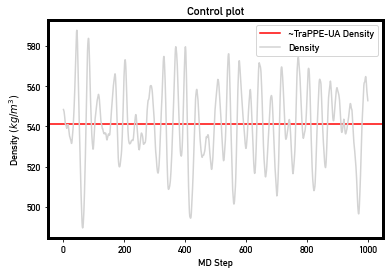

In [16]:
import numpy as np
import pylab as plt 

import panedr
from panedr import edr_to_df

data = edr_to_df("gmx_sim/npt.edr")

plt.rcParams['font.family'] = "DIN Alternate"
font = {'family' : 'DIN Alternate',
        'weight' : 'normal',
        'size'   : 12}

fig, ax = plt.subplots(1, 1)

ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["top"].set_linewidth(3)

ax.title.set_text('Control plot')
ax.set_xlabel(r"MD Step")
ax.set_ylabel('Density $(kg / m{^3})$')
ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.axhline(y=541, color='r', linestyle='-', label='~TraPPE-UA Density')

dt, density = list(), list()
for i, j in enumerate(data["Density"]):
    dt.append(i)
    density.append(j)
    
ax.plot(dt, density, "-", color='lightgray', label='Density')
ax.legend(loc="best")
plt.show()

In [ ]:
data.keys()